# Welcome to PsyNeuLink

PsyNeuLink is an integrated language and toolkit for creating cognitive models. It decreases the overhead required for cognitive modeling by providing standard building blocks (DDMS, Neural Nets, etc.) and the means to connect them together in a single environment. PsyNeuLink is designed to make the user think about computation in a "mind/brain-like" way while imposing minimal constraint on the type of models that can be implemented.

## How to get PsyNeuLink

PsyNeuLink is compatible with python versions >= 3.5, and is available through PyPI:

```python
pip install psyneulink
```
Or you can clone the github repo [here](https://github.com/PrincetonUniversity/PsyNeuLink). Download the package with the green "Clone or download" button on the right side of the page and "Download ZIP." Open the version of this Tutorial in the cloned folder before continuing on.

## Installation

To install the package, navigate to the cloned directory in a terminal, switch to your preferred python3 environment, then run the command __"pip install ."__ (make sure to include the period and to use the appropriate pip/pip3 command for python 3.5). All prerequisite packages will be automatically added to your enviroment.

For the curious, these are:
* numpy
* matplotlib
* toposort
* mpi4py
* typecheck-decorator


## Tutorial Overview

This tutorial is meant to get you accustomed to the structure of PsyNeuLink and be able to construct basic models. Starting with a simple 1-to-1 transformation, we will build up to making the Stroop model from Cohen et al. (1990). Let's get started!

### Imports and file structure

The following code block will import the necessary components for basic neural network models in PsyNeuLink. In particular, we need tools for handling *[systems](https://princetonuniversity.github.io/PsyNeuLink/System.html)*, *[processes](https://princetonuniversity.github.io/PsyNeuLink/Process.html)*, the set of specific *[mechanisms](https://princetonuniversity.github.io/PsyNeuLink/Mechanism.html)* that will make up our networks, and the *[projections](https://princetonuniversity.github.io/PsyNeuLink/Projection.html)* to connect them. We also import basic prerequisites and set up the jupyter environment for visualization.

In [1]:
import psyneulink as pnl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

### Creating a mechanism

*[Mechanisms](https://princetonuniversity.github.io/PsyNeuLink/Mechanism.html)* are the basic units of computation in PsyNeuLink. At their core is a parameterized *function* but they also contain the machinery to interact with input, output, control, and learning signals. Our first mechanism will perform a linear transformation on a scalar input. For now, we will initialize it by just specifying the *function* of the mechanism.

In [3]:
linear_transfer_mechanism = pnl.TransferMechanism(
    function=pnl.Linear(slope=1, intercept=0))

In this case, we didn't actually need to specify the slope and intercept as the function will default to reasonable values (in this case, 1 and 0 respectively).

In [4]:
linear_transfer_mechanism.execute([1])

array([[ 1.]])

Try reparamaterizing the mechanism and executing again before moving on.

### Organizing into Processes

Generally with PsyNeuLink, you won't be executing mechanisms as stand-alone entities. Rather, they will be encapsulated inside *[Processes](https://princetonuniversity.github.io/PsyNeuLink/Process.html)* and later *[Systems](https://princetonuniversity.github.io/PsyNeuLink/System.html)*. A process is a collection of mechanisms and projections to be executed serially. They may be thought of as a way to concatenate mechanisms into a single, more complex unit of analysis in order to simplify interacting with larger models.

The main parameter when initializing a process is its pathway, which is the order in which the mechanisms will execute. Of course, with only one mechanism in our process, the list has just one element.

To better see how the process runs, we also turn on output reporting. Reporting can happen at every level in PsyNeuLink so we set the preference for both the process and mechanism.

In [5]:
linear_transfer_process = pnl.Process(pathway = [linear_transfer_mechanism])

linear_transfer_mechanism.reportOutputPref = True
linear_transfer_process.reportOutputPref = True

In [6]:
linear_transfer_process.execute([4])



****************************************


''Process-0' process_base' executing with:
- pathway: ['TransferMechanism-0']
- input: [[4]]

'TransferMechanism-0'  executed:
- input:  4.0
- params:
	function: Linear
		intercept: 0
		slope: 1
	initial_value: 0
	integrator_mode: False
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 4.0

''Process-0' process_base' completed:
- output: 4.0


****************************************



array([ 4.])

Let's turn off the reporting and look at our process' output over a wider range of values.

---------------------------------------------------

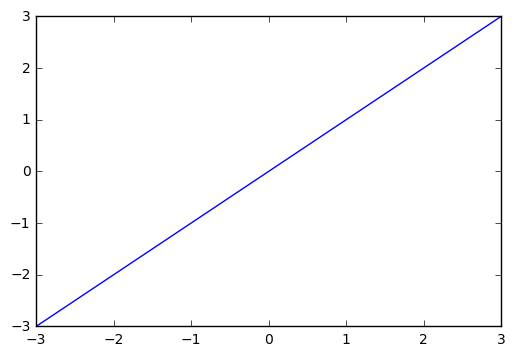

In [7]:
linear_transfer_mechanism.reportOutputPref = False
linear_transfer_process.reportOutputPref = False

xVals = np.linspace(-3, 3, num=51)
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    yVals[i] = linear_transfer_process.execute([xVals[i]])[0]
    # Progress bar
    print("-", end="")
plt.plot(xVals, yVals)
plt.show()

The previous cell provides a way to plot the net input-output function of a composed Process.  If you want to see the function associated with an individual Mechanism, there is simple way to do this (and because the current Process is only has one Mechanism the plotted function will be the same):

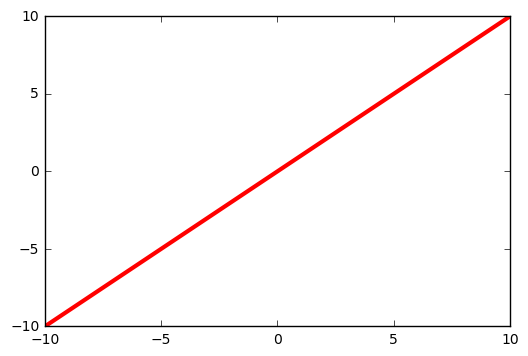

In [8]:
linear_transfer_mechanism.plot()

Now let's put it all together and make a new transfer process, this time with a logistic activation function. We will also extend our mechanism by giving it two units (operating on a 1x2 matrix) rather than the default one (operating on a scalar).

---------------------------------------------------

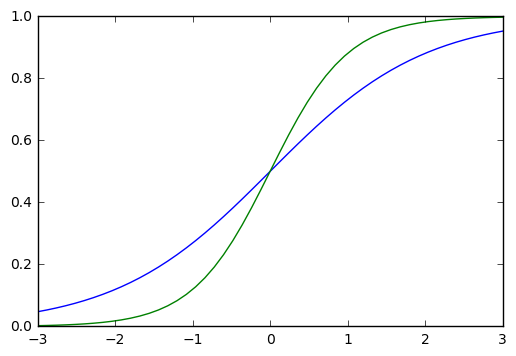

In [9]:
# Create the mechanism
logistic_transfer_mechanism = pnl.TransferMechanism(default_variable=[0, 0],
                                                function=pnl.Logistic(gain=1,
                                                                  bias=0))

# Package into a process
logistic_transfer_process = pnl.Process(pathway=[logistic_transfer_mechanism])

# Iterate and plot
xVals = np.linspace(-3, 3, num=51)
y1Vals = np.zeros((51,))
y2Vals = np.zeros((51,))
for i in range(xVals.shape[0]):
    # clarify why multiplying times 2
    output = logistic_transfer_process.execute([xVals[i], xVals[i] * 2])
    y1Vals[i] = output[0]
    y2Vals[i] = output[1]
    # Progress bar
    print("-", end="")
plt.plot(xVals, y1Vals)
plt.plot(xVals, y2Vals)
plt.show()

The `default_variable` parameter serves a dual function. It specifies the dimensionality of the mechanism as well as providing the inputs that will be given in the absence of explicit input at runtime.

You can also think of the functions in mechanisms as simple building blocks, and it is possible to combine them to create a wide variety of different functions, as in the next two examples.

---------------------------------------------------

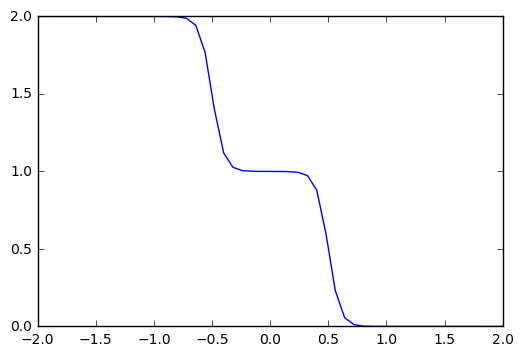

In [10]:
toymech2 = pnl.TransferMechanism(
    name='toymech2',
    function=pnl.Logistic(gain = -20, bias = -.5)
)

toymech3 = pnl.TransferMechanism(
    name='toymech3',
    function=pnl.Logistic(gain = -20, bias = .5),
)

toymech4 =pnl.TransferMechanism(
    name='toymech4',
    function=pnl.Linear()
)

toyprocess1 = pnl.Process(
    pathway=[toymech2, toymech4]    
)

toyprocess2 = pnl.Process(
    pathway=[toymech3, toymech4]    
)


toysystem2 = pnl.System(processes=[toyprocess1, toyprocess2],
                     name='SumLog')

toymech2.reportOutputPref = False
toymech3.reportOutputPref = False
toymech4.reportOutputPref = False

# Iterate and plot
xVals = np.linspace(-2, 2, num=51)
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    yVals[i] = toysystem2.execute([[xVals[i]],[xVals[i]]])[0]
    # Progress bar
    print("-", end="")
plt.plot(xVals, yVals)
plt.show()

---------------------------------------------------

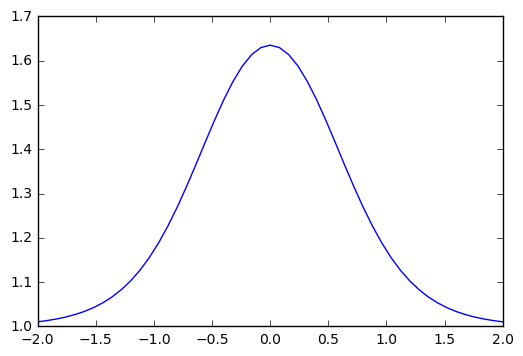

In [11]:
toymech2 = pnl.TransferMechanism(
    name='toymech2',
    function=pnl.Logistic(gain = 3, bias = -.5)
)

toymech3 = pnl.TransferMechanism(
    name='toymech3',
    function=pnl.Logistic(gain = -3, bias = .5),
)

toymech4 =pnl.TransferMechanism(
    name='toymech4',
    function=pnl.Linear()
)

toyprocess1 = pnl.Process(
    pathway=[toymech2, toymech4]    
)

toyprocess2 = pnl.Process(
    pathway=[toymech3, toymech4]    
)


toysystem2 = pnl.System(processes=[toyprocess1, toyprocess2],
                     name='SumLog')

toymech2.reportOutputPref = False
toymech3.reportOutputPref = False
toymech4.reportOutputPref = False

# Iterate and plot
xVals = np.linspace(-2, 2, num=51)
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    yVals[i] = toysystem2.execute([[xVals[i]],[xVals[i]]])[0]
    # Progress bar
    print("-", end="")
plt.plot(xVals, yVals)
plt.show()

### Adding Projections

To make more complex processes, we need a way to link mechanisms together. This is done through *[Projections](https://princetonuniversity.github.io/PsyNeuLink/Projection.html)*. A projection takes a mechanism output, multiplies it by the projection's mapping matrix, and delivers the transformed value to the next mechanism in the process.

---------------------------------------------------

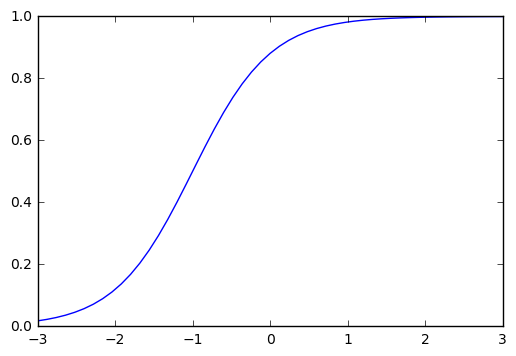

In [12]:
linear_input_unit = pnl.TransferMechanism(function=pnl.Linear(slope=2, intercept=2))
logistic_output_unit = pnl.TransferMechanism(function=pnl.Logistic())
mini_connected_network = pnl.Process(
    pathway=[linear_input_unit, pnl.IDENTITY_MATRIX, logistic_output_unit])

# Iterate and plot
xVals = np.linspace(-3, 3, num=51)
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    yVals[i] = mini_connected_network.execute([xVals[i]])[0]
    # Progress bar
    print("-", end="")
plt.plot(xVals, yVals)
plt.show()

If you want to plot the two Mechanism individually, the following cell allows you to do this.  

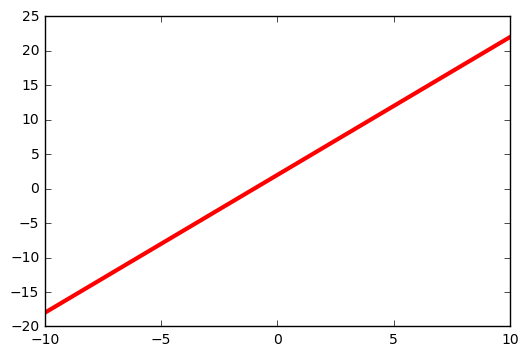

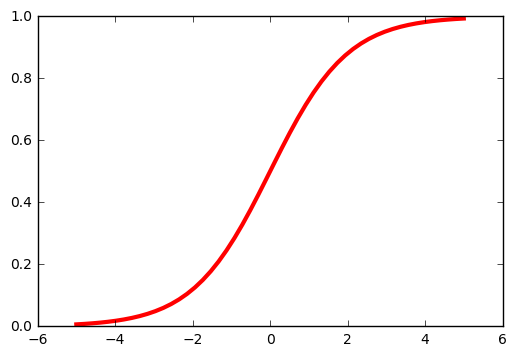

In [13]:
linear_input_unit.plot()
logistic_output_unit.plot()

`IDENTITY_MATRIX` is a keyword that provides a projection from the unit preceding it to the unit following that creates a one-to-one output to input projection between the two. Other useful projection keywords are [here](https://princetonuniversity.github.io/PsyNeuLink/Keywords.html#psyneulink.globals.keywords.MatrixKeywords.IDENTITY_MATRIX)

Now let's make our projection definition a bit more explicit.

---------------------------------------------------

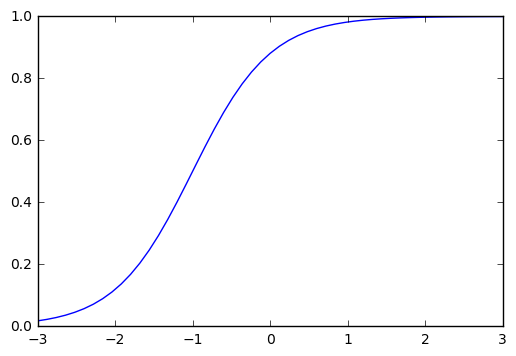

In [14]:
linear_input_unit = pnl.TransferMechanism(function=pnl.Linear(slope=2, intercept=2))
logistic_output_unit = pnl.TransferMechanism(function=pnl.Logistic())

mapping_matrix = np.asarray([[1]])
unit_mapping_projection = pnl.MappingProjection(sender=linear_input_unit,
                                            receiver=logistic_output_unit,
                                            matrix=mapping_matrix)
mini_connected_network = pnl.Process(
    pathway=[linear_input_unit, unit_mapping_projection, logistic_output_unit])

# Iterate and plot
xVals = np.linspace(-3, 3, num=51)
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    yVals[i] = mini_connected_network.execute([xVals[i]])[0]
    # Progress bar
    print("-", end="")
plt.plot(xVals, yVals)
plt.show()

This time we specified our mapping matrix (which is a 2-D numpy array) then explicitly initialized a *[MappingProjection](https://princetonuniversity.github.io/PsyNeuLink/MappingProjection.html)* with that matrix as well as its input and output mechanisms. Note: because we specified the input and output mechanisms in the projection itself, we didn't need to include it in the process pathway as it will infer its position from those parameters. Ultimately, however, this does the exact same thing as our keyword method above which is far less verbose for this common use case.

### Systems

The highest level at which models are considered in PsyNeuLink is that of the *[System](https://princetonuniversity.github.io/PsyNeuLink/System.html)*. A system is composed of one or more processes which can then run in unison. This allows system graphs to be more complex than the strictly linear ones of processes. Our first system will consist of two input nodes that converge on a single output mechanism. We will be modelling competition between color naming and word reading in the stroop task.

In [15]:
colors = pnl.TransferMechanism(default_variable=[0, 0], function=pnl.Linear,
                           name="Colors")
words = pnl.TransferMechanism(default_variable=[0, 0],
                          function=pnl.Linear(slope=1.5), name="Words")
response = pnl.TransferMechanism(default_variable=[0, 0], function=pnl.Logistic,
                             name="Response")

color_naming_process = pnl.Process(pathway=[colors, pnl.IDENTITY_MATRIX, response],
                               name="Color Naming")
word_reading_process = pnl.Process(pathway=[words, pnl.IDENTITY_MATRIX, response],
                               name="Word Reading")

# Should pass in scheduler or have system create new scheduler if scheduler=None
mini_stroop = pnl.System(processes=[color_naming_process, word_reading_process],
                     name='Stroop Model')

In the code above "colors" are assigned the default Linear function values of slope = 1, and intercept = 0.  And "words" are explicitly assigned a slope of 1.5.  These slope values can be thought of as weights, asserting that words will be processed more than colors.

The order of processes in the system initialization is important here as it is the order we will feed inputs to the system.  

We can also visually inspect the system by creating a graph: 

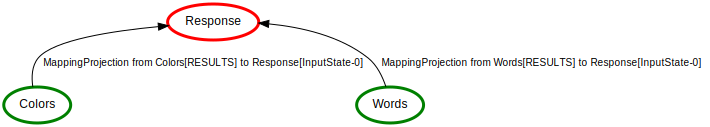

In [16]:
# mini_stroop.show_graph(output_fmt = 'jupyter')

PsyNeuLink provides multiple convenient ways to inspect a model (to better understand existing models, and to debug and trouble-shoot while building your own models).  Along with turning on reporting, you can use the system_name.show() to get a summary. 

In [17]:
mini_stroop.show()


---------------------------------------------------------

Stroop Model

	Control enabled: False

	Processes:
		Color Naming [learning enabled: False]
		Word Reading [learning enabled: False]

	Execution sets: 
		Set 0:
			{ Colors Words }
		Set 1:
			{ Response }


Now we are ready to give the system inputs and run the model.  In this very simple model two possible color inputs are distinguished as [1, 0] or [0, 1], and likewise for words.  For both color and word you can think of [1, 0] as red, and [0, 1] as blue.  In the following cell, the input is the word "blue" [0, 1] written in red colored ink [1, 0].  

In [18]:
input = { words: [0, 1],
        colors: [1, 0]}

mini_stroop.run(input)

[[array([ 0.73105858,  0.81757448])]]

The first output value corresponds to the strength to respond red, and the second value is the strength to respond blue.  Because the task is to respond to the word, and the word is blue, the second value is higher.  And because the ink is colored red, there is also some activity associated with red.  

In [19]:
input_dict = {colors: [0, 1],
              words: [0, 1]}
mini_stroop.run(input_dict)

[[array([ 0.73105858,  0.81757448])], [array([ 0.5       ,  0.92414182])]]

The first pair of values in the output is from our first run of the model with incongruent input [red color / blue word]and the second pair of values is from the second run with congruent input [blue / blue]. As modeled, we see that word reading beats out color naming when there is conflict, but congruent stimuli elicit an even stronger response.  

### Pre-trained Complete Stroop Model

Let's practice using systems by recreating the more complex stroop model from Cohen et al (1990). Later we will train the network ourselves, but for now we will explicitly model the learned weights.

In [20]:
ink_color = pnl.TransferMechanism(default_variable=[0, 0], function=pnl.Linear())
word = pnl.TransferMechanism(default_variable=[0, 0], function=pnl.Linear())
task_demand = pnl.TransferMechanism(default_variable=[0, 0], function=pnl.Linear())

hidden_layer = pnl.TransferMechanism(default_variable=[0, 0, 0, 0],
                                 function=pnl.Logistic(bias=-4))

output_layer = pnl.TransferMechanism(default_variable=[0, 0], function=pnl.Linear())

color_mapping_matrix = np.asarray([[2.2, -2.2, 0, 0], [-2.2, 2.2, 0, 0]])
color_projection = pnl.MappingProjection(sender=ink_color, receiver=hidden_layer,
                                     matrix=color_mapping_matrix)
word_mapping_matrix = np.asarray([[0, 0, 2.6, -2.6], [0, 0, -2.6, 2.6]])
word_projection = pnl.MappingProjection(sender=word, receiver=hidden_layer,
                                    matrix=word_mapping_matrix)
task_mapping_matrix = np.asarray([[4, 4, 0, 0], [0, 0, 4, 4]])
task_projection = pnl.MappingProjection(sender=task_demand, receiver=hidden_layer,
                                    matrix=task_mapping_matrix)
output_mapping_matrix = np.asarray(
    [[1.3, -1.3], [-1.3, 1.3], [2.5, -2.5], [-2.5, 2.5]])
pnl.MappingProjection(sender=hidden_layer, receiver=output_layer,
                  matrix=output_mapping_matrix)

color_naming_process = pnl.Process(pathway=[ink_color, hidden_layer, output_layer])
word_reading_process = pnl.Process(pathway=[word, hidden_layer, output_layer])
task_process = pnl.Process(pathway=[task_demand, hidden_layer, output_layer])

stroop_model = pnl.System(
    processes=[color_naming_process, word_reading_process, task_process])

ink_color.reportOutputPref = True
word.reportOutputPref = True
task_demand.reportOutputPref = True
hidden_layer.reportOutputPref = True

In the next cell we will run the model with inputs.  The "ink_color" and "word" are the same as the previous model, and the addition of task demand allows us to specify whether the task is to name the color of ink [0, 1], or to read the word [1, 0].  The output can be thought of as activation strengths of two possible responses [red, blue].  

In [21]:
input_dict = {ink_color: [1, 0],
              word: [0, 1],
              task_demand: [1, 0]}
stroop_model.run(input_dict)


'TransferMechanism-7'  executed:
- input:  [array([ 0.,  1.])]
- params:
	function: Linear
		intercept: 0.0
		slope: 1.0
	initial_value: 0 0
	integrator_mode: False
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 0.0 1.0

'TransferMechanism-8'  executed:
- input:  [array([ 1.,  0.])]
- params:
	function: Linear
		intercept: 0.0
		slope: 1.0
	initial_value: 0 0
	integrator_mode: False
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.0 0.0

'TransferMechanism-6'  executed:
- input:  [array([ 1.,  0.])]
- params:
	function: Linear
		intercept: 0.0
		slope: 1.0
	initial_value: 0 0
	integrator_mode: False
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.0 0.0

'TransferMechanism-9'  executed:
- input:  [array([ 6.2,  1.8, -2.6,  2.6])]
- params:
	function: Logistic
		bias: -4
		gain: 1.0
		offset: 0.0
	initial_value: 0 0 0 0
	integrator_mode: False
	noise: 0.0
	time_scale: TimeScale.TRIAL
- output: 1.0 0.997 0.802 0.999


[[array([-0.48726836,  0.48726836])]]

To get a better sense of how the model works, try reverse engineering by changing each of the inputs (remember the options are only [1,0] or [0,1]) one at a time and running the model. 

We can also inspect the model as a graph or using .show(). 

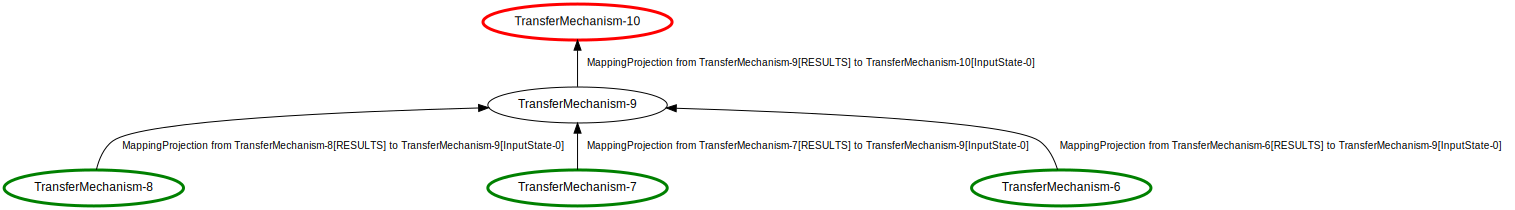

In [22]:
# stroop_model.show_graph(output_fmt = 'jupyter')

In [23]:
stroop_model.show()


---------------------------------------------------------

System-0

	Control enabled: False

	Processes:
		Process-8 [learning enabled: False]
		Process-9 [learning enabled: False]
		Process-10 [learning enabled: False]

	Execution sets: 
		Set 0:
			{ TransferMechanism-6 TransferMechanism-7 TransferMechanism-8 }
		Set 1:
			{ TransferMechanism-9 }
		Set 2:
			{ TransferMechanism-10 }


You can see that this model's components were not given names, so the graph and summary are more difficult to understand.  To get little practice modifying the code, you can add names using the same syntax as was used for the mini_stroop model above.   

## Configuring Systems

The following cells provide some basic examples of how to build extremely simple to increasingly complex systems.  These systems aren't configured to do anything in particular -- they are merely included to show you how to get started building systems with different graph configurations.  Input mechanisms are green and output mechanisms are red

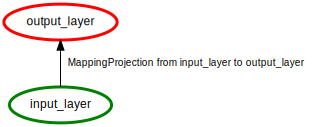

In [24]:
input_layer = pnl.TransferMechanism(
    name='input_layer',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

output_layer = pnl.TransferMechanism(
    name='output_layer',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

simple_process1 = pnl.Process(pathway=[input_layer, output_layer])

simple_system1 = pnl.System(
    processes=[simple_process1])


# simple_system1.show_graph(output_fmt = 'jupyter')

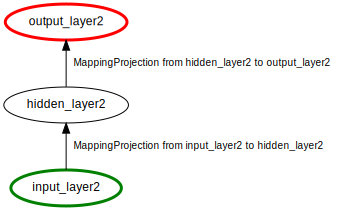

In [25]:
input_layer2 = pnl.TransferMechanism(
    name='input_layer2',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)


hidden_layer2 = pnl.TransferMechanism(
    name='hidden_layer2',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

output_layer2 = pnl.TransferMechanism(
    name='output_layer2',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

simple_process2 = pnl.Process(pathway=[input_layer2, hidden_layer2, output_layer2])

simple_system2 = pnl.System(processes=[simple_process2])

## the previous two lines of code builiding a 3 layer system could alternatively take the following form:

# simple_process2a = process(pathway=[input_layer2, hidden_layer2])
# simple_process2b = process(pathway=[hidden_layer2, output_layer2])
#
# simple_system2 = system(processes=[simple_process2a, simple_process2b])



# simple_system2.show_graph(output_fmt = 'jupyter')

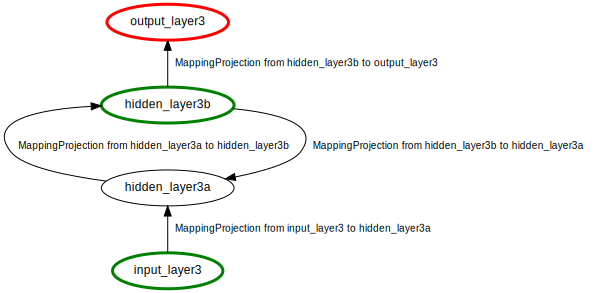

In [26]:
input_layer3 = pnl.TransferMechanism(
    name='input_layer3',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)


hidden_layer3a = pnl.TransferMechanism(
    name='hidden_layer3a',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

hidden_layer3b = pnl.TransferMechanism(
    name='hidden_layer3b',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

output_layer3 = pnl.TransferMechanism(
    name='output_layer3',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

simple_process3a = pnl.Process(pathway=[input_layer3, hidden_layer3a])
simple_process3b = pnl.Process(pathway=[hidden_layer3a, hidden_layer3b])
simple_process3c = pnl.Process(pathway=[hidden_layer3b, hidden_layer3a])
simple_process3d = pnl.Process(pathway=[hidden_layer3a, hidden_layer3b])
simple_process3e = pnl.Process(pathway=[hidden_layer3b, output_layer3])


simple_system3 = pnl.System(processes=[simple_process3a, simple_process3b, simple_process3c, simple_process3d, simple_process3e])


# simple_system3.show_graph(output_fmt = 'jupyter')

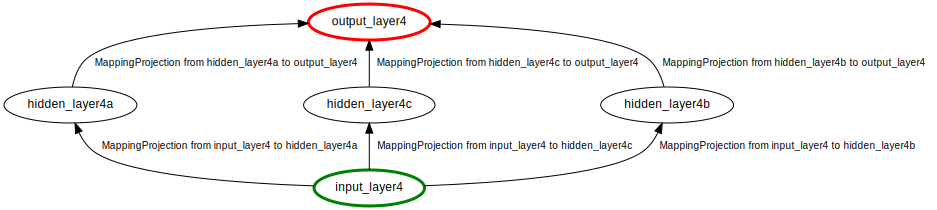

In [27]:
input_layer4 = pnl.TransferMechanism(
    name='input_layer4',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

hidden_layer4a = pnl.TransferMechanism(
    name='hidden_layer4a',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

hidden_layer4b = pnl.TransferMechanism(
    name='hidden_layer4b',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

hidden_layer4c = pnl.TransferMechanism(
    name='hidden_layer4c',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

output_layer4 = pnl.TransferMechanism(
    name='output_layer4',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

simple_process4a = pnl.Process(pathway=[input_layer4, hidden_layer4a, output_layer4])
simple_process4b = pnl.Process(pathway=[input_layer4, hidden_layer4b, output_layer4])
simple_process4c = pnl.Process(pathway=[input_layer4, hidden_layer4c, output_layer4])


simple_system4 = pnl.System(processes=[simple_process4a, simple_process4b, simple_process4c])


# simple_system4.show_graph(output_fmt = 'jupyter')

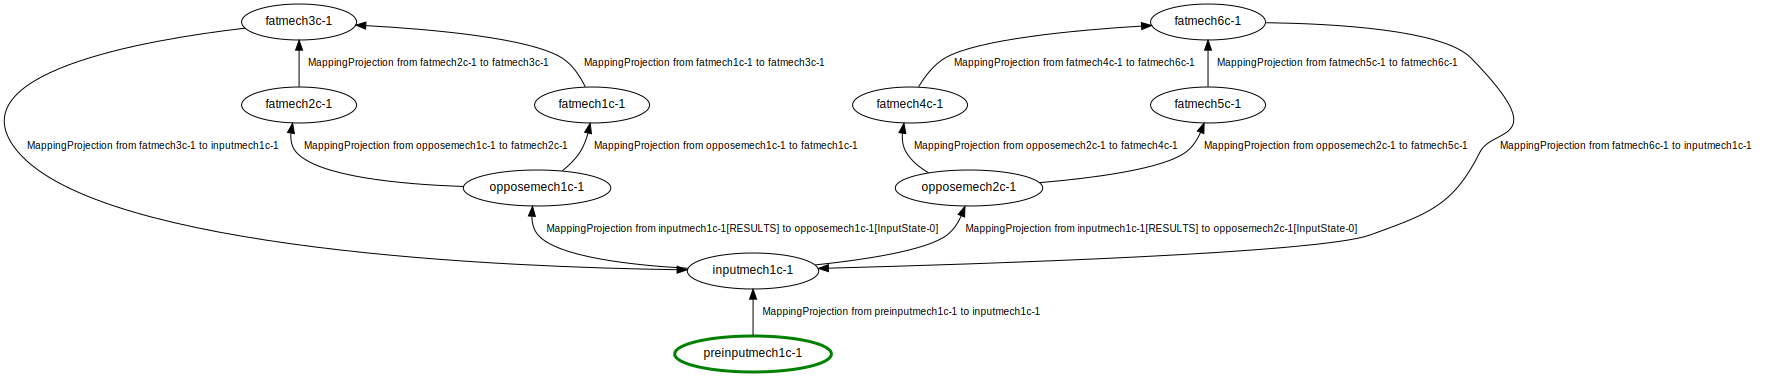

In [29]:
preinputmech1c = pnl.TransferMechanism(
    name='preinputmech1c',
    function=pnl.Linear(slope=1, intercept=0),
    size = 2
)

inputmech1c = pnl.TransferMechanism(
    name='inputmech1c',
    function=pnl.Linear(slope=1, intercept=0),
    size = 2
)

opposemech1c = pnl.TransferMechanism(
    name='opposemech1c',
    #function=pnl.Logistic(gain=3,bias=1),
    function=pnl.Linear(),
    size = 2
)

opposemech2c = pnl.TransferMechanism(
    name='opposemech2c',
    #function=pnl.Logistic(gain=3,bias=1),
    function=pnl.Linear(),
    size = 2
)

fatmech1c = pnl.TransferMechanism(
    name='fatmech1c',
    function=pnl.Logistic()
)

fatmech2c = pnl.TransferMechanism(
    name='fatmech2c',
    function=pnl.Logistic(),
)

fatmech3c =pnl.TransferMechanism(
    name='fatmech3c',
    function=pnl.Linear()
)

fatmech4c = pnl.TransferMechanism(
    name='fatmech4c',
    function=pnl.Logistic()
)

fatmech5c = pnl.TransferMechanism(
    name='fatmech5c',
    function=pnl.Logistic(),
)

fatmech6c =pnl.TransferMechanism(
    name='fatmech6c',
    function=pnl.Linear()
)

# Create projections
xy_mapmat = np.array(((1,0),(0,-1)))
yx_mapmat = np.array(((-1,0),(0,1)))
                

# Create processes

toyprocess1cp = pnl.Process(
    pathway=[preinputmech1c, inputmech1c]
)

toyprocess1c = pnl.Process(
    pathway=[inputmech1c, xy_mapmat, opposemech1c]
)

toyprocess2c = pnl.Process(
    pathway=[inputmech1c, yx_mapmat, opposemech2c]    
)

toyprocess3c = pnl.Process(
    pathway=[opposemech1c, fatmech1c, fatmech3c]    
)

toyprocess4c = pnl.Process(
    pathway=[opposemech1c, fatmech2c, fatmech3c]    
)

toyprocess5c = pnl.Process(
    pathway=[opposemech2c, fatmech4c, fatmech6c]    
)

toyprocess6c = pnl.Process(
    pathway=[opposemech2c, fatmech5c, fatmech6c]    
)

toyprocess7c = pnl.Process(
    pathway=[fatmech3c, inputmech1c]    
)

toyprocess8c = pnl.Process(
    pathway=[fatmech6c, inputmech1c]    
)

# Create system


toysystem1c = pnl.System(processes=[toyprocess1cp, toyprocess1c, toyprocess2c, toyprocess3c, toyprocess4c, toyprocess5c, toyprocess6c, toyprocess7c, toyprocess8c],
                     name='toysystem1c')

# toysystem1c.show_graph(output_fmt = 'jupyter')

This is currently the end of the tutorial, but more content is being added weekly. For further examples, look to the Scripts folder inside your PsyNeuLink directory for several functioning models.